# Analysis of NFT tokens in terra network - Whales collection

The dataset that will be analysed describes transactions and features about whales collection. Data was downloaded from randomearth.io and saved into a .txt file. All presented data is from 12.10.21 to 18.10.21. 

# Cleaning data

For each NFT we were looking if "mint_nft" is present in "execute_msg" because only then the details about characteristics are available. The characteristics were needed to prepare the first dataframe. To make second dataframe data regarding executed transactions were used.

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [39]:
with open('data_dict.txt', 'r') as f:
    filedata = f.read()

In [40]:
data_dict = eval(filedata)

In [41]:
messages_all = []
extensions = []
for msg in data_dict[0:-1]:
    messages = []
    for i in range(len(msg['tx']['value']['msg'])):
        d = {'type': msg['tx']['value']['msg'][i]['type'], 'hash_id': msg['txhash'],
        'exe_msg': msg['tx']['value']['msg'][i]['value']['execute_msg'], 'timestamp': msg['timestamp']}
        if 'mint_nft' in msg['tx']['value']['msg'][i]['value']['execute_msg'].keys():
            extensions.append(msg['tx']['value']['msg'][i]['value']['execute_msg']['mint_nft'])
        messages.append(d)
    messages_all.append(messages)

Also lists with token ids and types of traits were made.

In [42]:
token_ids = []
trait_types = []
for i in range(len(extensions)):
    num = len(extensions[i]['extension']['attributes'])
    for j in range(num):
        trait_types.append(extensions[i]['extension']['attributes'][j]['trait_type'])
        token_ids.append(extensions[i]['token_id'])
        
trait_types.append('token_id')
trait_types.append('name')
trait_types.append('image')

List with executed transactions was defined.

In [43]:
trans_list = []
for dat in messages_all[0:-1]:
  for datt in dat:
    if 'execute_order' in datt['exe_msg'].keys():
      trans_list.append(datt['exe_msg'])
      trans_list.append(datt['timestamp'])

From executed transactions the interesting data (maker asset and taker asset) was saved into list of dictionaries. In most cases the maker has 'token_id' and 'contract_addr' attributes and 'taker' has info about amount and currency, as maker offers its product for sale and taker distributes money and purchase the product. But sometimes the situation is reverse and for this purpose the column 'who' was created - to know who manages the money.

In [44]:
tr_li = []
dict_tr = {}
for i in range(0, len(trans_list), 2):
  dict_tr = {}
  maker = trans_list[i]['execute_order']['order']['order']['maker_asset']
  taker = trans_list[i]['execute_order']['order']['order']['taker_asset']
  if 'nft' in list(maker['info'].keys())[0]:
    dict_tr['token_id'] = maker['info']['nft']['token_id']
    dict_tr['contr'] = maker['info']['nft']['contract_addr']
    dict_tr['amount'] = taker['amount']
    dict_tr['denom'] = taker['info']['native_token']['denom']
    dict_tr['time'] = trans_list[i+1]
    dict_tr['who'] = 'taker'
    tr_li.append(dict_tr)
  else:
    dict_tr['token_id'] = taker['info']['nft']['token_id']
    dict_tr['contr'] = taker['info']['nft']['contract_addr']
    dict_tr['amount'] = maker['amount']
    dict_tr['denom'] = maker['info']['native_token']['denom']
    dict_tr['time'] = trans_list[i + 1]
    dict_tr['who'] = 'maker'
    tr_li.append(dict_tr)

Values prepared this way were saved into a dataframe.

In [45]:
tr_df = pd.json_normalize(tr_li)
tr_df = tr_df.drop_duplicates()
tr_df = tr_df.sort_values(by=['time', 'token_id'])

In [46]:
tr_df.head()

,token_id,contr,amount,denom,time,who
471,128151525273825821293592383919082729383,terra1jdt2wnfhgy4ptk6m5kxacyj0k6e8rc7e2ugulz,100000000,uluna,2021-10-12T17:22:23Z,taker
470,128151525273825821293592383919082729383,terra1jdt2wnfhgy4ptk6m5kxacyj0k6e8rc7e2ugulz,100000000,uluna,2021-10-12T17:22:30Z,taker
469,111198211705347563535897385756665112226,terra1jdt2wnfhgy4ptk6m5kxacyj0k6e8rc7e2ugulz,150000000,uluna,2021-10-12T17:22:58Z,taker
468,139621590672445192521436487002979291304,terra1jdt2wnfhgy4ptk6m5kxacyj0k6e8rc7e2ugulz,149000000,uluna,2021-10-12T17:23:57Z,taker
467,228644559127842003713497305877093511287,terra1jdt2wnfhgy4ptk6m5kxacyj0k6e8rc7e2ugulz,150000000,uluna,2021-10-12T17:24:03Z,taker


In [47]:
tr_df.describe()

,token_id,contr,amount,denom,time,who
count,464,464,464,464,464,464
unique,352,1,114,1,449,2
top,232067013751720890221194343628096319153,terra1jdt2wnfhgy4ptk6m5kxacyj0k6e8rc7e2ugulz,100000000,uluna,2021-10-12T17:31:11Z,taker
freq,5,464,34,464,2,411


There are 464 events inside 'executed_order' and 352 unique transactions. 

In [48]:
tr_df2 = tr_df['amount']
pd.options.display.float_format = "{:.2f}".format
tr_df2.astype(float).describe()

count          464.00
mean     106773896.31
std       96362490.17
min        1120000.00
25%       75000000.00
50%       88000000.00
75%      107250000.00
max     1350000000.00
Name: amount, dtype: float64

There are some basic statistics for prices of NFT tokens. The mean price is above 106 mln ulunas.

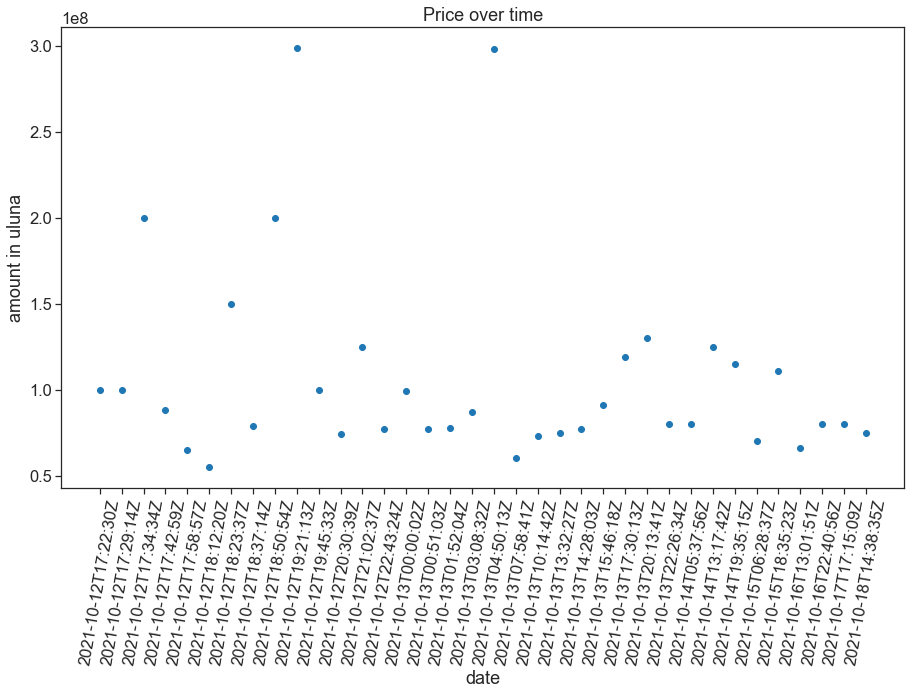

In [49]:
tr_df2 = tr_df.copy()
tr_df2 = tr_df2.drop_duplicates(subset=['token_id'], keep='last')
tr_df2 = tr_df2.sort_values(by=['time'])
plt.rcParams['figure.figsize'] = [13, 10]
plt.scatter(tr_df2['time'][::10], [float(i) for i in tr_df2['amount'][::10]])
plt.xlabel("date")
plt.xticks(rotation=80)
plt.ylabel('amount in uluna')
plt.title("Price over time")
plt.tight_layout()

There is no visible trend in price over time. 

Dictionary with trait values was made. To deal with the fact that not every whale has every trait defined value "None" was used.

In [50]:
trait_types = set(trait_types)
traits = {tr: [] for tr in trait_types}

for i in range(len(extensions)):
    traits['name'].append(extensions[i]['extension']['name'])
    traits['image'].append(extensions[i]['extension']['image'])
    traits['token_id'].append(extensions[i]['token_id'])
    no = len(traits['image'])
    num = len(extensions[i]['extension']['attributes'])
    for tr in trait_types:
        for j in range(num):
            if extensions[i]['extension']['attributes'][j]['trait_type'] == tr:
                traits[extensions[i]['extension']['attributes'][j]['trait_type']].append(extensions[i]['extension']['attributes'][j]['value'])
    for ls in traits.values():
        if len(ls) < no:
            ls.append("None")
            
df_traits = pd.DataFrame(traits)

Additional columns with number of used traits for each row.

In [51]:
df_traits['no_of_traits'] = 16 - df_traits.isin(['None']).sum(axis=1)
df_traits = df_traits.reindex(columns=['name', 'Hat', 'Primary Prop', 'Tail Accessory', 'Sidekick', 'Beached?',
       'Eye Accessory', 'Filleted?', 'Eye Color', 'Tail Type', 'Species',
       'Color', 'Mouth', 'Eye Type', 'BG Color', 'Secondary Prop',
       'Body Accessory', 'no_of_traits', 'token_id', 'image'])
df_traits.head()

,name,Hat,Primary Prop,Tail Accessory,Sidekick,Beached?,Eye Accessory,Filleted?,Eye Color,Tail Type,Species,Color,Mouth,Eye Type,BG Color,Secondary Prop,Body Accessory,no_of_traits,token_id,image
0,Whale #118,Elf,GiftRed,None,None,No,None,No,Black,Regular,Orca,Black / White,None,Sleepy,Red,None,None,10,179298554005268377866705773059029530584,ipfs://QmWPpPhgjvjLTaeRngz1E5Y84GrzmPhunZDcnFC...
1,Whale #967,MowhawkPurple,Popsicle,None,None,No,None,No,Black,Regular,Whale,Glow Green,None,Angry,Purple,None,None,10,93091297589663042301185757942324687666,ipfs://QmRvMK2Kzuzq5jqAkKBaLKrtbMNwuneHRT98NyU...
2,Whale #358,RamHorns,None,None,None,Yes,None,No,White,Regular,Orca,Black / White,None,Beached,Green,None,SpikedCollar,10,132631103572683298250849583619061003996,ipfs://QmVaXp9xhGdTDbhFUQFBXQ4d4NvKYdiCuvwgr3K...
3,Whale #55,MowhawkRed,None,None,Seahorse,No,None,Yes,LaserEyes,Regular,Whale,Black / Black,None,Regular,Grey,None,None,10,187445413553592199561065748013726825223,ipfs://QmQymUrY4Qgv7Wj9KqBqowmMHDeYUx5Xv7wJuU3...
4,Whale #922,None,None,None,Seahorse,No,None,No,Black,Regular,Whale,Glow Purple,None,Regular,Pink,None,None,9,217051057542981952204586371033378002195,ipfs://QmUZCkUD87mmDEL1aSQqWfSkNb22GzBYwpiGjG3...


There are 16 different traits, where two of them are boolean and the rest - categorical.

In [52]:
df_traits.describe(include=[object])

,name,Hat,Primary Prop,Tail Accessory,Sidekick,Beached?,Eye Accessory,Filleted?,Eye Color,Tail Type,Species,Color,Mouth,Eye Type,BG Color,Secondary Prop,Body Accessory,token_id,image
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,1000,60,44,5,7,2,5,2,11,5,2,64,8,4,20,12,7,1000,1000
top,Whale #118,None,None,None,None,No,None,No,Black,Regular,Whale,Black / White,None,Regular,Black,None,None,179298554005268377866705773059029530584,ipfs://QmWPpPhgjvjLTaeRngz1E5Y84GrzmPhunZDcnFC...
freq,1,189,417,815,779,877,834,941,732,939,901,108,636,576,187,845,896,1,1


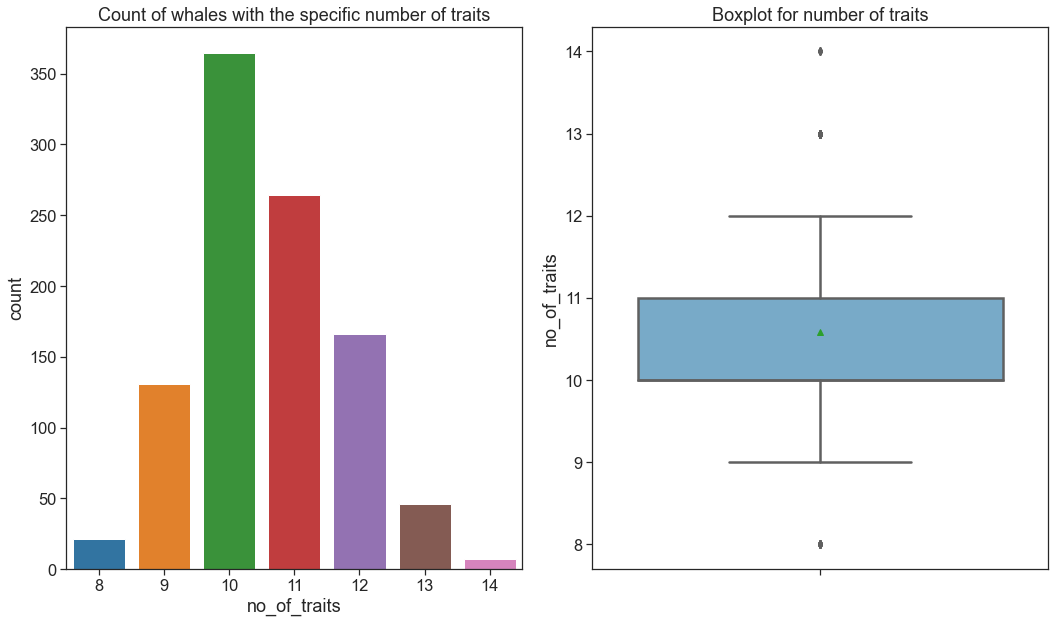

In [53]:
# sns.set(font_scale=1.5)
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# sns.reset_orig()
fig, ax = plt.subplots(1,2,figsize=(15,9))
sns.countplot(x=df_traits['no_of_traits'], ax=ax[0]).set_title('Count of whales with the specific number of traits')
sns.boxplot(y=df_traits['no_of_traits'].astype('float'), showmeans=True, palette="Blues", ax=ax[1]).set_title('Boxplot for number of traits')
fig.tight_layout()

The range of number of traits is from 8 to 14. The most common number of traits is 10. There is no item with all 16 traits. 
The mean is between 10 and 11 traits. Values 8, 13 and 14 are outliers. 

Example terraWhales with the biggest number of traits and the lowest.

In [54]:
from IPython.display import Image
Image(url="https://d75aawrtvbfp1.cloudfront.net/ipfs://QmV3Zgnye3cH1nHnMcdEGjmfqduqGGE2PuJwjx9XdXsh17", width=400, height=400)

In [55]:
Image(url="https://d75aawrtvbfp1.cloudfront.net/ipfs://QmfPA1EVbnSP12k3oJPm1Y4d6oexCe4VD7MriXQSwnmemW", width=400, height=400)

# Preparing data for further analysis

To make the data carry more information about what they say some changes were made. For example if the column with name of trait was "Beached?" and values were only boolean - the change was to make values say "not_beached" or "beached". Also columns such as "image" or "name" were deleted, because they will not be helpful in trait statistics analysis.

In [56]:
df_ngram = pd.DataFrame(traits)
df_ngram['no_of_traits'] = 16 - df_ngram.isin(['None']).sum(axis=1)
df_ngram = df_ngram.reindex(columns=['name', 'Hat', 'Primary Prop', 'Tail Accessory', 'Sidekick', 'Beached?',
       'Eye Accessory', 'Filleted?', 'Eye Color', 'Tail Type', 'Species',
       'Color', 'Mouth', 'Eye Type', 'BG Color', 'Secondary Prop',
       'Body Accessory', 'no_of_traits', 'token_id', 'image'])

In [57]:
eye_colors = []
for elem in df_ngram['Eye Color']:
    if 'Eye' not in elem:
        eye_colors.append(elem + "Eyes")
    else:
        eye_colors.append(elem)
df_ngram['Eye Color'] = eye_colors

beached = []
for elem in df_ngram['Beached?']:
    if 'Yes' in elem:
        beached.append('Beached')
    else:
        beached.append("Not_beached")
df_ngram['Beached?'] = beached

BG = []
for elem in df_ngram['BG Color']:
    BG.append(elem + "_BG")
df_ngram['BG Color'] = BG


tails = []
for elem in df_ngram['Tail Type']:
    tails.append(elem + "Tail")
df_ngram['Tail Type'] = tails

filet = []
for elem in df_ngram['Filleted?']:
    if 'Yes' in elem:
        filet.append('Filleted')
    else:
        filet.append("Not_filleted")
df_ngram['Filleted?'] = filet
del df_ngram['image']
del df_ngram['name']

Now the dataframe looks like:

In [58]:
df_ngram.head()

,Hat,Primary Prop,Tail Accessory,Sidekick,Beached?,Eye Accessory,Filleted?,Eye Color,Tail Type,Species,Color,Mouth,Eye Type,BG Color,Secondary Prop,Body Accessory,no_of_traits,token_id
0,Elf,GiftRed,None,None,Not_beached,None,Not_filleted,BlackEyes,RegularTail,Orca,Black / White,None,Sleepy,Red_BG,None,None,10,179298554005268377866705773059029530584
1,MowhawkPurple,Popsicle,None,None,Not_beached,None,Not_filleted,BlackEyes,RegularTail,Whale,Glow Green,None,Angry,Purple_BG,None,None,10,93091297589663042301185757942324687666
2,RamHorns,None,None,None,Beached,None,Not_filleted,WhiteEyes,RegularTail,Orca,Black / White,None,Beached,Green_BG,None,SpikedCollar,10,132631103572683298250849583619061003996
3,MowhawkRed,None,None,Seahorse,Not_beached,None,Filleted,LaserEyes,RegularTail,Whale,Black / Black,None,Regular,Grey_BG,None,None,10,187445413553592199561065748013726825223
4,None,None,None,Seahorse,Not_beached,None,Not_filleted,BlackEyes,RegularTail,Whale,Glow Purple,None,Regular,Pink_BG,None,None,9,217051057542981952204586371033378002195


Next the function to count rarity was defined.

In [59]:
def trait_rarity(trait, value):
    data = df_ngram[trait]
    count = data.value_counts()[value]
    return count/len(data)

For each trait a column with rarity count was added. 

In [60]:
for trait in df_ngram.columns.values:
    trait_rarity_list = []
    for i in range(1000):
        value = df_ngram[trait][i]
        rarity = trait_rarity(trait, value)
        trait_rarity_list.append(rarity)
    df_ngram[trait+"_rarity"] = trait_rarity_list

Next function for counting number of traits which each NFT has was defined.

In [61]:
def count_trait(trait_type, df):
    count = 0
    for value in df[trait_type]:
        if value != 'None':
            count += 1
    return count

# Data analysis

For Whales dataset not every element has every trait defined. First we want to see how often every trait is defined.

In [62]:
df_ngram.head()

,Hat,Primary Prop,Tail Accessory,Sidekick,Beached?,Eye Accessory,Filleted?,Eye Color,Tail Type,Species,...,Tail Type_rarity,Species_rarity,Color_rarity,Mouth_rarity,Eye Type_rarity,BG Color_rarity,Secondary Prop_rarity,Body Accessory_rarity,no_of_traits_rarity,token_id_rarity
0,Elf,GiftRed,None,None,Not_beached,None,Not_filleted,BlackEyes,RegularTail,Orca,...,0.94,0.10,0.11,0.64,0.19,0.08,0.84,0.90,0.36,0.00
1,MowhawkPurple,Popsicle,None,None,Not_beached,None,Not_filleted,BlackEyes,RegularTail,Whale,...,0.94,0.90,0.01,0.64,0.12,0.10,0.84,0.90,0.36,0.00
2,RamHorns,None,None,None,Beached,None,Not_filleted,WhiteEyes,RegularTail,Orca,...,0.94,0.10,0.11,0.64,0.12,0.06,0.84,0.05,0.36,0.00
3,MowhawkRed,None,None,Seahorse,Not_beached,None,Filleted,LaserEyes,RegularTail,Whale,...,0.94,0.90,0.06,0.64,0.58,0.06,0.84,0.90,0.36,0.00
4,None,None,None,Seahorse,Not_beached,None,Not_filleted,BlackEyes,RegularTail,Whale,...,0.94,0.90,0.01,0.64,0.58,0.07,0.84,0.90,0.13,0.00


In [63]:
df_traits2 = df_traits[['Hat', 'Primary Prop', 'Tail Accessory', 'Sidekick', 'Beached?',
       'Eye Accessory', 'Filleted?', 'Eye Color', 'Tail Type', 'Species',
       'Color', 'Mouth', 'Eye Type', 'BG Color', 'Secondary Prop',
       'Body Accessory']]
trait_types.remove('name')
trait_types.remove('token_id')
trait_types.remove('image')

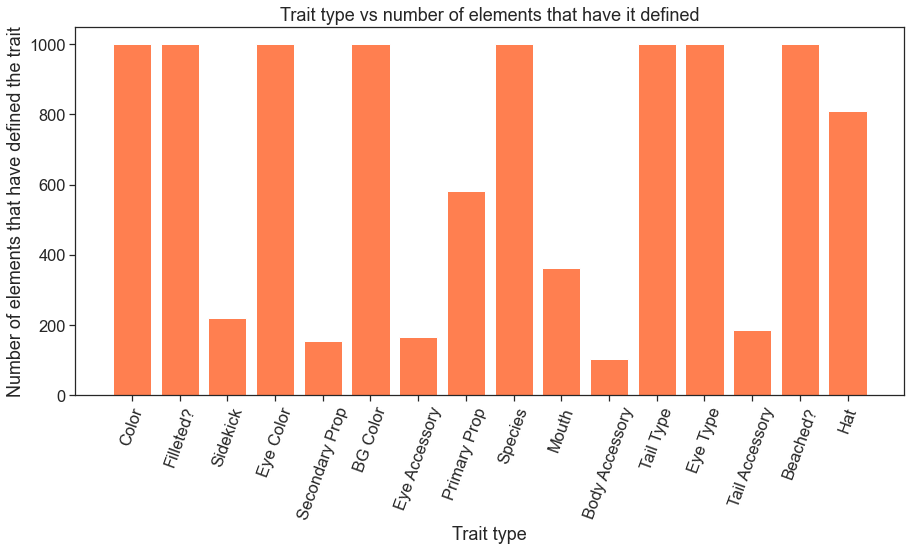

In [64]:
no_of_traits = {t: count_trait(t, df_traits2) for t in trait_types}

plt.rcParams['figure.figsize'] = [13, 8]
plt.bar(no_of_traits.keys(), no_of_traits.values(), color='coral')
plt.xlabel("Trait type")
plt.xticks(rotation=70)
plt.ylabel("Number of elements that have defined the trait")
plt.title("Trait type vs number of elements that have it defined")
plt.tight_layout()

Some traits such as 'Eye Type', 'Beached?', 'Eye Color', 'Tail Type', 'Species', 'BG Color', 'Color' and 'Filleted?' are always defined. But traits such as 'Body Accessory', 'Eye Accessorry', 'Secondary Prop' are specified only for less than 200 TerraWhales.

Also abundance of different values for every trait might be useful. Function for counting different values is defined below.

In [65]:
def count_different_trait(trait_type, df):
    count = 0
    trait_value = []
    for value in df[trait_type]:
        if value != 'None' and value not in trait_value:
            count += 1
            trait_value.append(value)
    return count

Below there is plot of number of different values for every trait.

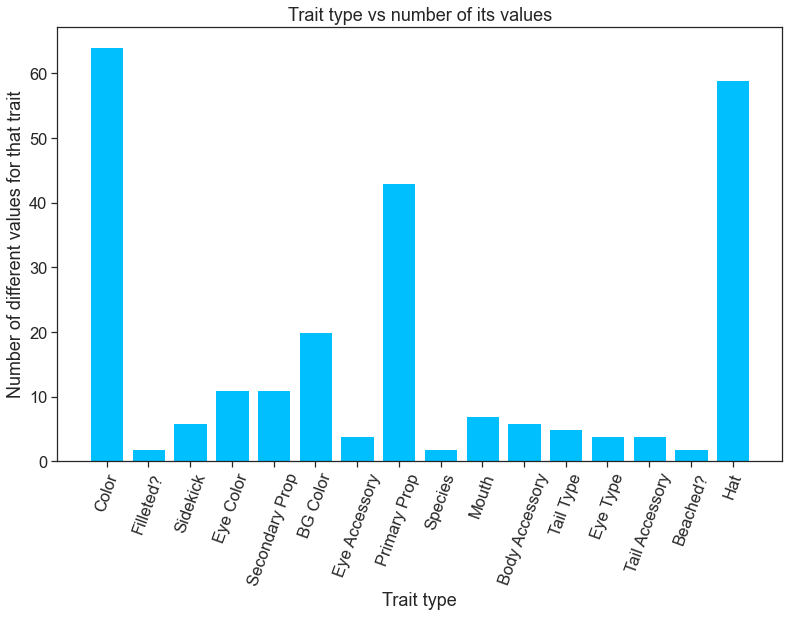

In [66]:
trait_types2 = trait_types
# trait_types2.remove('name')
# trait_types2.remove('image')
# trait_types2.remove('token_id')
no_of_df_traits = {t: count_different_trait(t, df_ngram) for t in trait_types2}
plt.bar(no_of_df_traits.keys(), no_of_df_traits.values(), color='deepskyblue')
plt.xlabel("Trait type")
plt.xticks(rotation=70)
plt.ylabel("Number of different values for that trait")
plt.title("Trait type vs number of its values")
plt.show()

As we can see "Beached?" and "Filleted?" are very low - there are exactly two possible values for this trait since they are boolean. Also only two values are for trait "Species" - Whale or Orca are possible. The most variate characteristics are "Color", "Hat" and "Primary Prop".

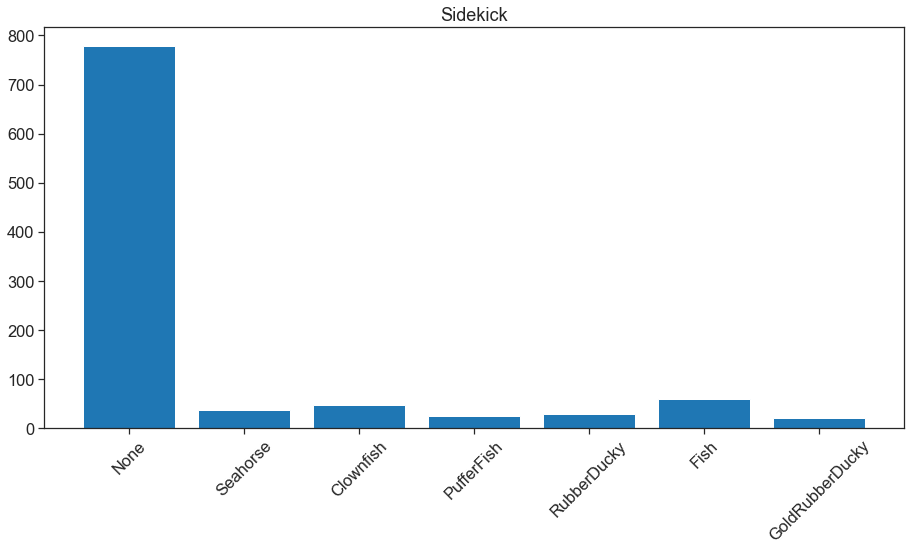

In [67]:
def plot_trait(trait):
    trait_count = {}
    for i in range(1000):
        value = df_ngram[trait][i]
        if value in trait_count.keys():
            trait_count[value] += 1
        else:
            trait_count[value] = 1
    plt.rcParams['figure.figsize'] = [13, 8]
    plt.bar(trait_count.keys(), trait_count.values())
    plt.xticks(rotation=45)
    plt.title(trait)
    plt.tight_layout()
plot_trait('Sidekick')   

Among 'Sidekick' trait values there are 7 different possibilities, where the most common is 'None', which means that the whale does not have the sidekick. Other than 'None', fish is the most often used. 

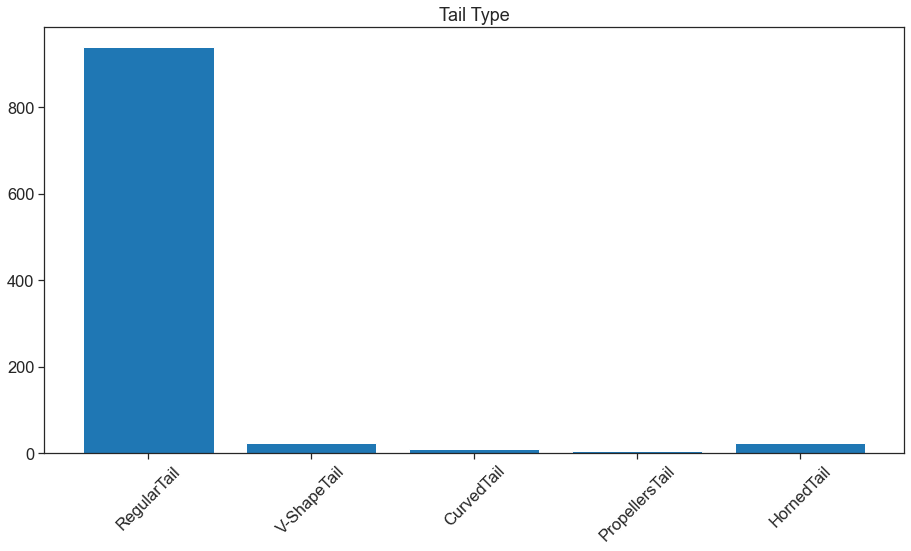

In [68]:
plot_trait('Tail Type')

There are 5 different values for 'Tail Type'. The vast majority has the regular tail.

In [69]:
tokens_id = tr_df['token_id']
tokens_id = tokens_id.drop_duplicates()

traits = df_ngram[df_ngram['token_id'].isin(list(tokens_id))]
del traits['token_id_rarity']


Column with count number of executed transactions for every token was added.

In [70]:
trans_tokens = tr_df['token_id']
trans_count = {token: 0 for token in trans_tokens.drop_duplicates()}
for token in trans_tokens.drop_duplicates():
    count = trans_tokens.value_counts()[token]
    trans_count[token] = count
count_tokens = pd.DataFrame.from_dict(trans_count, orient='index', columns=['number_of_trans'])

In [71]:
tr_df = tr_df.drop_duplicates(subset=['token_id'], keep='last')
tr_df = tr_df.set_index('token_id')
traits = traits.set_index('token_id')
whole_whale = pd.concat([tr_df, count_tokens, traits], axis=1)

<AxesSubplot:>

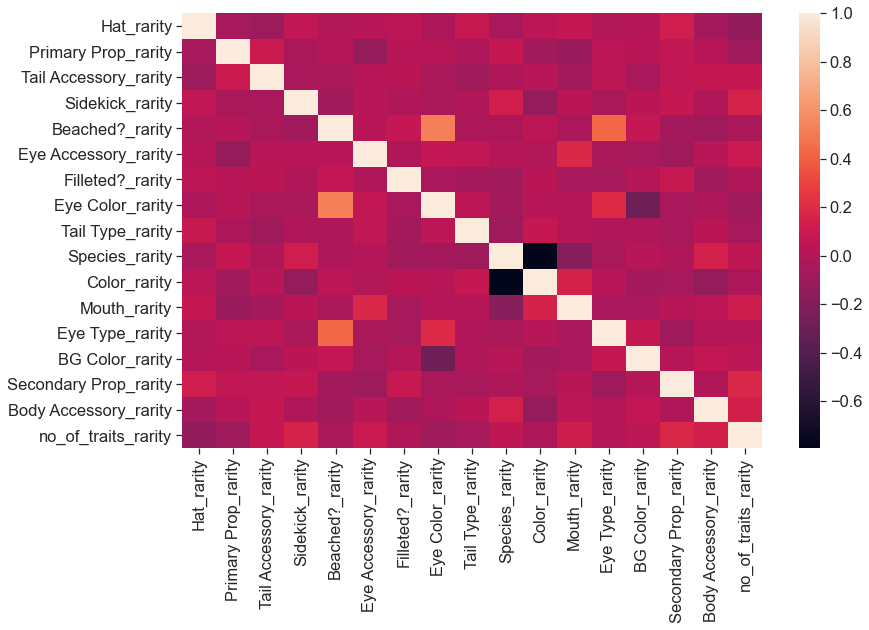

In [72]:
df = whole_whale.loc[:, 'Hat_rarity':'no_of_traits_rarity']
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

From the heatmap we can see that the low rarity for species is negatively corelated with color rarity. We can see positive corelation for the beached rarity and eye color. Other than that there are no strong corelations.

# Rarity ranking

Often rarity of traits for a NFT has a lot to do with its price. To describe how rare a given NFT is the rarity scores were introduced. Rarity score is calculated for every token. It is a sum of inversed trait rarities, where trait rarity is a value that describes how rare is the specific value of a trait.

In [73]:
whole_whale_ww = whole_whale.copy()


whole_whale_ww.loc[:, 'Hat_rarity':'Body Accessory_rarity'] = \
    whole_whale_ww.loc[:, 'Hat_rarity':'Body Accessory_rarity'].apply(lambda x: 1/x)
whole_whale_ww['rarity_score'] = whole_whale_ww.loc[:, 'Hat_rarity':'Body Accessory_rarity'].sum(axis=1)

whole_whale_ww = whole_whale_ww.sort_values(by=['rarity_score'])

In [74]:
print(whole_whale_ww['rarity_score'][-5:])

171071429235825166882018143773470681631    874.26
263607589318549369908418115146951860918   1116.51
140566925291259327857893656273259165084   1641.65
171620197277979847235281122428323279590   1685.37
194308570233953687463030147031490454344   1832.56
Name: rarity_score, dtype: float64


By our rarity ranking rank 1 has whale #682 with rarity score 1832.558839. It was sold for 1350 lunas. Next are whales #998 and #997. Whale 998 was sold for 969 and whale 997 is currently for sale for 420. Ranks 4 and 5 have whales #154 and #1000. Whale #154 is now for sale for 240 and whale #1000 was sold for 225. So we can say that in our ranking for top 5 whales the price is directly proportional to rarity score. We also compared our ranking with ranking  on https://notfoundterra.com/terrawhale . Results are slightly different – that might be because we count not having a certain feature as a feature. We think we cant just ignore these traits. To compare – our top 5 have ranks 1, 3, 4, 11 and 13 in notfoundterra ranking. Their top 5 whales are: #682, #885, #998, #997 and #239. And their prices are: 1350, 799 (which is cheaper than whale with rank 2 in our ranking), 969, 420 and 1424. So ranks are not exactly proportional to prices – at least for top 5 rare whales. To see if our rarity ranking is directly proportional also for other whales, not just top5 plot was made.

<AxesSubplot:xlabel='amount', ylabel='rarity_score'>

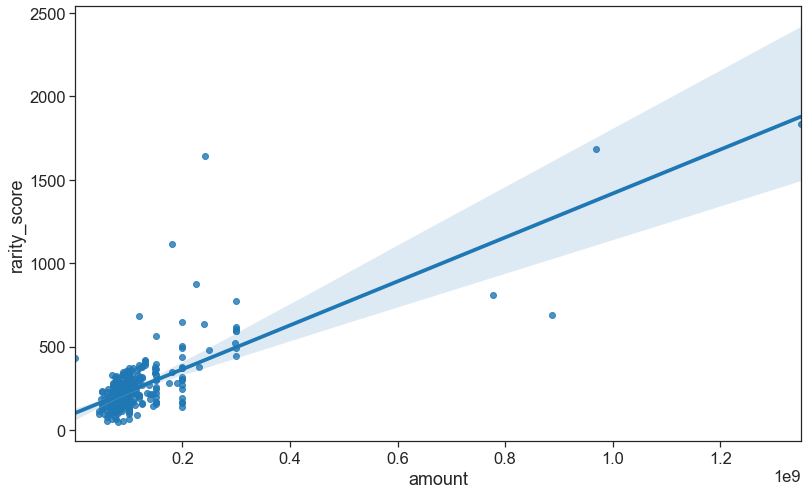

In [75]:
whole_whale_ww['amount'] = [float(i) for i in whole_whale_ww['amount']]
sns.regplot(x="amount", y="rarity_score", data=whole_whale_ww)

Based on our rarity scoring model and fitted regression line, we can see linear dependecy for amount and rarity score.

# Summary

1. TerraWhales collection is not relatively numerous so the dataset was not so large. Furthermore, this collection is special because items are not randomly generated.
2. Besides the fact there are 16 traits that can be defined for each NFT, not even one has all of them. This can make a number of traits another characteristics that could be used in future rarity rankings. 
3. 'None' values are so common that should not be disregarded.
4. There is no visible trend in price amount over time. Additionally, values are mainly ditributed between 50 mln and 200 mln ulunas. Anyway, sometimes we can observe some unusual prices.

In [76]:
Image(url="https://d75aawrtvbfp1.cloudfront.net/ipfs://QmeF22nYng4pLwXHvATwf3Z5q9w6Z5J5hFvGLmT4LTYTeJ", width=400, height=400)